<a href="https://colab.research.google.com/github/kokolight/MetacriticProject/blob/main/DataScienceProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataScience Project


## Creating the data set - Crawling and API


### Main problem -
* Gaming companies develop games for years and cannot predict if their game will be sucessfull or not.

### Data -
Metacritic -

Description: Games ranking and reviews

Website: https://www.metacritic.com/

RAWG - 
Website: https://rawg.io

### Web scraping

### Data we scrape:
- Name
- Release Date
- Metascore
- Userscore

### Data we get from API
- Singleplayer - True/False
- Multiplayer - True/False
- Achievements count
- Youtube related videos count
- Average playtime
- Is part of a series
- Publisher
- Developer
- Which consoles
- What genres
- Maturaty Rating

### Imports

In [429]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import threading
import re
import os.path
import math
from os import path
import json
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import preprocessing
from ast import literal_eval
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

### Variables

In [430]:

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.93 Safari/537.36"
}
RAWG_API_KEY = "224eb0b778a54d6cafafc1ac80deb15d"
FILE_NAME = "video_games_ratings.csv"
BASE_URL = "https://www.metacritic.com"
BROWSE_URL = BASE_URL + "/browse/games/score/metascore/all/all/filtered?"
COLUMNS = [
    "game_name",
    "metascore",
    "userscore",
    "publisher",
    "developer",
    "release_date",
    "maturity_rating",
    "singleplayer",
    "multiplayer",
    "onXbox",
    "onPC",
    "onPlaystation",
    "onSwitch",
    "onWii",
    "onMac",
    "onIOS",
    "onAndroid",
    "youtube_videos_count",
    "achievements_count",
    "ratings_count",
    "average_playtime",
    "game_series_count",
]

month_dict = {
    "January": "1",
    "February": "2",
    "March": "3",
    "April": "4",
    "May": "5",
    "June": "6",
    "July": "7",
    "August": "8",
    "September": "9",
    "October": "10",
    "November": "11",
    "December": "12",
}


 ### Function: Get all games data (by pages)


In [431]:
def metacritic_games_data(start_page, end_page):
    index = 1
    game_records = []

    current_data = pd.read_csv(FILE_NAME, index_col=0) if path.exists(FILE_NAME) else pd.DataFrame(columns=COLUMNS)
    soup = BeautifulSoup(features="lxml")
    # Get all games in all pages
    for i in range(start_page, end_page):
        current_page = i
        pages_count = end_page - start_page
        print(f"Page: {current_page}/{pages_count}")
        page_url = BROWSE_URL + "page={0}".format(i)
        req = requests.get(page_url, headers=HEADERS)
        soup.append(bs4.BeautifulSoup(req.text, "lxml"))

    trs = set(soup.select("tr"))
    spacers = set(soup.select("tr.spacer"))
    games = trs - spacers

    # For each game
    for game in games:
        game_name = game.select("h3")[0].text
        # Already exists
        if (not current_data.empty) and (game_name in current_data["game_name"].values):
            print(f"Already in dataframe - {game_name}")
            index = index + 1
            continue
        metascore = game.select("div.metascore_w.game")[0].text
        userscore = game.select("div.metascore_w.user.game")[0].text
        date = game.select("div.clamp-details")[0].find_all("span")[2].text.replace(",", "")
        date_splitted = date.split(" ")
        release_date = "{day}-{month}-{year}".format(
            day=date_splitted[1], month=month_dict[date_splitted[0]], year=date_splitted[2]
        )
        game_href = game.find("a", class_="title", href=True)["href"]
        game_slug = re.findall(".*\/(.*)$", game_href)[0]

        print(f"Game: {game_name}")

        game_object = get_game_data(game_slug, game_name, metascore, userscore, release_date)
        if len(game_object):
            game_records.append(game_object)
        else:
            print(f"Couldn't get game details: {game_name}")

        print("Progress: {:.2f}%".format((index / len(games)) * 100))
        index = index + 1

    new_data = pd.DataFrame(game_records)

    if not new_data.empty:
        current_data = current_data.append(new_data, ignore_index=True)
        current_data.to_csv("./video_games_ratings.csv", mode="w")
    return current_data


### Function: Get single game data

In [432]:
def get_game_data(game_slug, game_name, metascore, userscore, release_date):
    rawg_details = get_game_rawg_details(game_slug)
    if len(rawg_details) == 0:
        return []

    return {
        "game_name": game_name,
        "release_date": release_date,
        "metascore": metascore,
        "userscore": userscore,
        "publisher": rawg_details["publisher"],
        "developer": rawg_details["developer"],
        "maturity_rating": rawg_details["maturity_rating"],
        "average_playtime": rawg_details["avg_playtime"],
        "achievements_count": rawg_details["achievements_count"],
        "youtube_videos_count": rawg_details["youtube_videos_count"],
        "singleplayer": rawg_details["singleplayer"],
        "multiplayer": rawg_details["multiplayer"],
        "onXbox": rawg_details["onXbox"],
        "onPC": rawg_details["onPC"],
        "onPlaystation": rawg_details["onPlaystation"],
        "onSwitch": rawg_details["onSwitch"],
        "onMac": rawg_details["onMac"],
        "onIOS": rawg_details["onIOS"],
        "onWii": rawg_details["onWii"],
        "onAndroid": rawg_details["onAndroid"],
        "ratings_count": rawg_details["ratings_count"],
        "genres": rawg_details["genres"],
        "game_series_count": rawg_details["game_series_count"],
    }


### Get game additional data from RAWG

In [433]:

def get_game_rawg_details(game_name):
    try:
        RAWG_URL = f"https://api.rawg.io/api/games/{game_name}?key={RAWG_API_KEY}"
        data = requests.get(RAWG_URL, headers=HEADERS).json()
        # Check if not redirected to another page
        while "redirect" in data:
            game_name = data["slug"]
            RAWG_URL = f"https://api.rawg.io/api/games/{game_name}?key={RAWG_API_KEY}"
            data = requests.get(RAWG_URL, headers=HEADERS).json()
        # Not found
        if "detail" in data:
            return []
        if len(data):
            game_details = {
                "achievements_count": data["parent_achievements_count"],
                "avg_playtime": data["playtime"],
                "youtube_videos_count": data["youtube_count"],
                "singleplayer": False,
                "multiplayer": False,
                "game_series_count": data["game_series_count"],
                "maturity_rating": data["esrb_rating"]["name"][0] if data["esrb_rating"] else None,
                "onXbox": False,
                "onPC": False,
                "onPlaystation": False,
                "onSwitch": False,
                "onWii": False,
                "onMac": False,
                "onIOS": False,
                "onAndroid": False,
                "genres": [],
                "platforms_count": len(data["platforms"]),
                "publisher": data["publishers"][0]["name"] if len(data["publishers"]) else None,
                "developer": data["developers"][0]["name"] if len(data["developers"]) else None,
                "ratings_count": data["ratings_count"],
            }
            for tag in data["tags"]:
                if tag["slug"] == "singleplayer":
                    game_details["singleplayer"] = True
                if tag["slug"] == "multiplayer":
                    game_details["multiplayer"] = True
            for platform in data["platforms"]:
                if bool(re.match(".*playstation.*", platform["platform"]["slug"])):
                    game_details["onPlaystation"] = True
                if bool(re.match(".*xbox.*", platform["platform"]["slug"])):
                    game_details["onXbox"] = True
                if bool(re.match(".*pc.*", platform["platform"]["slug"])):
                    game_details["onPC"] = True
                if bool(re.match(".*switch.*", platform["platform"]["slug"])):
                    game_details["onSwitch"] = True
                if bool(re.match(".*wii.*", platform["platform"]["slug"])):
                    game_details["onWii"] = True
                if bool(re.match(".*macos.*", platform["platform"]["slug"])):
                    game_details["onMac"] = True
                if bool(re.match(".*ios.*", platform["platform"]["slug"])):
                    game_details["onIOS"] = True
                if bool(re.match(".*android.*", platform["platform"]["slug"])):
                    game_details["onAndroid"] = True
            for genre in data["genres"]:
                game_details["genres"].append(genre["slug"])
            return game_details
        else:
            print(f"{game_name} is not available!")
            return []
    except error:
        print(error)
        exit
        return []

### Main - Retrieveing all the data

In [436]:
df = metacritic_games_data(1, 186)
print(df)

Page: 1/1
Game: Guitar Hero II
Progress: 1.00%
Game: Virtua Fighter 4
Progress: 2.00%
Game: Test Drive Le Mans
Progress: 3.00%
Game: Eternal Darkness: Sanity's Requiem
Progress: 4.00%
Game: Metal Gear Solid 3: Subsistence
Progress: 5.00%
Game: Gears of War 2
Progress: 6.00%
Game: Virtua Fighter 4: Evolution
Couldn't get game details: Virtua Fighter 4: Evolution
Progress: 7.00%
Game: Tom Clancy's Splinter Cell Pandora Tomorrow
Progress: 8.00%
Game: SoulCalibur II
Progress: 9.00%
Game: Warcraft III: Reign of Chaos
Couldn't get game details: Warcraft III: Reign of Chaos
Progress: 10.00%
Game: Quake III Arena
Couldn't get game details: Quake III Arena
Progress: 11.00%
Game: Tom Clancy's Splinter Cell
Progress: 12.00%
Game: Hades
Progress: 13.00%
Game: Burnout 3: Takedown
Progress: 14.00%
Game: Resident Evil 2
Progress: 15.00%
Game: Paper Mario
Progress: 16.00%
Game: Divinity: Original Sin II - Definitive Edition
Couldn't get game details: Divinity: Original Sin II - Definitive Edition
Prog

NameError: name 'error' is not defined

# Exploring the data

## Functions

In [14]:
def load_csv(filename):
    return pd.read_csv(filename, parse_dates=['release_date'])

def outlier_detection_iqr(df):
    df2 = df.copy()
    numeric_cols = df2.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        df2.loc[(df2[col] < Q1 - 1.5*IQR) | (df2[col] > Q3 + 1.5*IQR ),col] = np.nan
    return df2

def get_first_element(array):
    return array[0] if array else "None"

def get_frequent_elements(df, col_name, num_top_elements):
    return df[col_name].value_counts().head(num_top_elements)

In [201]:
def prepare_dataset(df):
    
  # Dealing with 'bad' data - duplicates and null values
        df2 = df.copy()
        df2 = df2.drop_duplicates(subset=['game_name'])

        # Dealing with missing userscore values
        df2 = df2.drop(df2[df2['userscore'] == 'tbd'].index)
        
        # Removing NaN values
        df2.dropna(subset=['publisher', 'developer', 'maturity_rating'], inplace=True)

        # Dealing with games that haven't been released yet
        today = pd.Timestamp('today')
        df2 = df2.drop(df2[df2['release_date'] > today].index)

        df2['userscore'] = df2['userscore'].astype(float)
        # Convert genres string to array
        df2['genres'] = df['genres'].apply(literal_eval)

        onMobile = df2['onIOS'] | df2['onAndroid']
        averageScore = df2['metascore'] + (df2['userscore']*10)
        # Making Boolean values to int
        df2['onXbox'] = df2['onXbox'].astype(int)
        df2['onPC'] = df2['onPC'].astype(int)
        df2['onPlaystation'] = df2['onPlaystation'].astype(int)
        df2['onSwitch'] = df2['onSwitch'].astype(int)
        df2['onWii'] = df2['onWii'].astype(int)
        df2['onMac'] = df2['onMac'].astype(int)
        df2['onIOS'] = df2['onIOS'].astype(int)
        df2['onAndroid'] = df2['onAndroid'].astype(int)
        df2['singleplayer'] = df2['singleplayer'].astype(int)
        df2['multiplayer'] = df2['multiplayer'].astype(int)
        df2['onMobile'] = onMobile.astype(int)
        df2['release_year'] = [date.year for date in df2['release_date']]
        df2['average_score'] = averageScore / 2
        df2['average_playtime'] = df2['average_playtime'].astype(float)
        df2.drop(columns=['release_date'], inplace=True)
        df2['genres'] = df2['genres'].apply(get_first_element)
        success_rates = []
        
        for index, row in df2.iterrows():
            if row['average_score'] <= 55.0 or row['average_playtime'] < 1.0:
                successRate = 0
            elif (row['average_score'] > 55.0) and (row['average_score'] <= 75.0) or (row['average_playtime'] >= 1.0 and row['average_playtime'] < 4.0): 
                successRate = 1
            elif (row['average_score'] > 75.0) or (row['average_playtime'] >= 4.0): 
                successRate = 2
                
            success_rates.append(successRate)
        
        df2['success_rate'] = success_rates
        # Reset indices
        df2 = df2.reset_index(drop=True)
        
        return df2

In [ ]:
# Loading the data
df = load_csv("video_games_ratings.csv")
# Drop first column
df = df.iloc[:, 1:]
# df
df = prepare_dataset(df)

In [103]:
# Show the unrelease games
today = pd.Timestamp('today')
df[df['release_date'] > today]

,game_name,metascore,userscore,publisher,developer,release_date,maturity_rating,singleplayer,multiplayer,onXbox,...,onAndroid,youtube_videos_count,achievements_count,ratings_count,average_playtime,game_series_count,genres,onMobile,average_score,success_rate
276,Crash Bandicoot 4: It's About Time,86,8.0,Activision Blizzard,Toys for Bob,2021-12-03,E,0,0,1,...,0,0,28,57,0.0,20,action,0,83.0,0
337,Chicory: A Colorful Tale,88,6.6,Greg Lobanov,Finji,2021-10-06,E,1,1,0,...,0,0,21,2,2.0,0,adventure,0,77.0,1
924,The Legend of Heroes: Trails of Cold Steel IV,81,8.4,NIS America,Engine Software,2021-09-04,T,1,0,0,...,0,0,31,0,46.0,0,role-playing-games-rpg,0,82.5,2
973,Little Nightmares II,82,8.0,Bandai Namco Entertainment,Tarsier Studios,2021-11-02,T,1,0,1,...,0,0,17,122,6.0,1,action,0,81.0,2
1731,Game Builder Garage,77,8.0,Nintendo,Nintendo,2021-11-06,E,0,0,0,...,0,0,0,0,0.0,0,arcade,0,78.5,0


In [105]:
# Exploring the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606 entries, 0 to 3605
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   game_name             3606 non-null   object 
 1   metascore             3606 non-null   int64  
 2   userscore             3606 non-null   float64
 3   publisher             3606 non-null   object 
 4   developer             3606 non-null   object 
 5   maturity_rating       3606 non-null   object 
 6   singleplayer          3606 non-null   int32  
 7   multiplayer           3606 non-null   int32  
 8   onXbox                3606 non-null   int32  
 9   onPC                  3606 non-null   int32  
 10  onPlaystation         3606 non-null   int32  
 11  onSwitch              3606 non-null   int32  
 12  onWii                 3606 non-null   int32  
 13  onMac                 3606 non-null   int32  
 14  onIOS                 3606 non-null   int32  
 15  onAndroid            

In [107]:
# show the dataframe
df

,game_name,metascore,userscore,publisher,developer,maturity_rating,singleplayer,multiplayer,onXbox,onPC,...,youtube_videos_count,achievements_count,ratings_count,average_playtime,game_series_count,genres,onMobile,release_year,average_score,success_rate
0,INSIDE,93,8.3,Playdead,Playdead,T,1,0,1,1,...,1000000,14,1786,4.0,0,action,1,2016,88.0,2
1,Burnout 3: Takedown,93,9.0,Electronic Arts,Criterion Games,T,0,1,1,0,...,159866,0,104,23.0,3,racing,0,2004,91.5,2
2,The Elder Scrolls V: Skyrim,92,6.6,Bethesda Softworks,Bethesda Softworks,M,1,0,1,1,...,1000000,76,3380,45.0,14,action,0,2011,79.0,2
3,Persona 4 Golden,93,8.6,SEGA,Atlus,M,1,0,0,1,...,1000000,36,397,5.0,8,role-playing-games-rpg,0,2012,89.5,2
4,SSX 3,93,8.8,Electronic Arts,Electronic Arts Canada,E,1,1,1,0,...,0,0,26,0.0,6,sports,0,2003,90.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,Deca Sports Freedom,26,3.7,Hudson Entertainment,HUDSON SOFT CO.,E,0,0,1,0,...,0,0,1,0.0,0,sports,0,2010,31.5,0
3602,Kengo: Legend of the 9,38,4.1,Genki,GENKI,M,0,0,1,0,...,0,21,3,0.0,0,action,0,2007,39.5,0
3603,Things on Wheels,41,6.0,LOAD,LOAD,E,0,0,1,0,...,0,5,1,0.0,0,racing,0,2010,50.5,0
3604,Umbrella Corps,36,2.0,Capcom,Capcom,M,1,1,0,1,...,192642,41,61,5.0,21,action,0,2016,28.0,0


# EDA

In [157]:
consoles_df = pd.DataFrame({})
xbox_count = df[df['onXbox']==1].count()['game_name']
ps_count = df[df['onPlaystation']==1].count()['game_name']
wii_count =  df[df['onWii']==1].count()['game_name']
switch_count =  df[df['onSwitch']==1].count()['game_name']
pc_count =  df[df['onPC']==1].count()['game_name']
ios_count = df[df['onIOS']==1].count()['game_name']
mac_count = df[df['onMac']==1].count()['game_name']
android_count = df[df['onAndroid']==1].count()['game_name']


consoles_df.append({'xbox': xbox_count, 'playstation': ps_count, 'wii': wii_count, 'switch': switch_count, 'pc': pc_count, 'mac': mac_count, 'android': android_count, 'ios': ios_count}, ignore_index=True)

# fig, axes = plt.subplots(1,1, figsize=(30,7))
consoles_df
# plt.plot(values)

""



## Games count by publisher - Barplot

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Games Count')

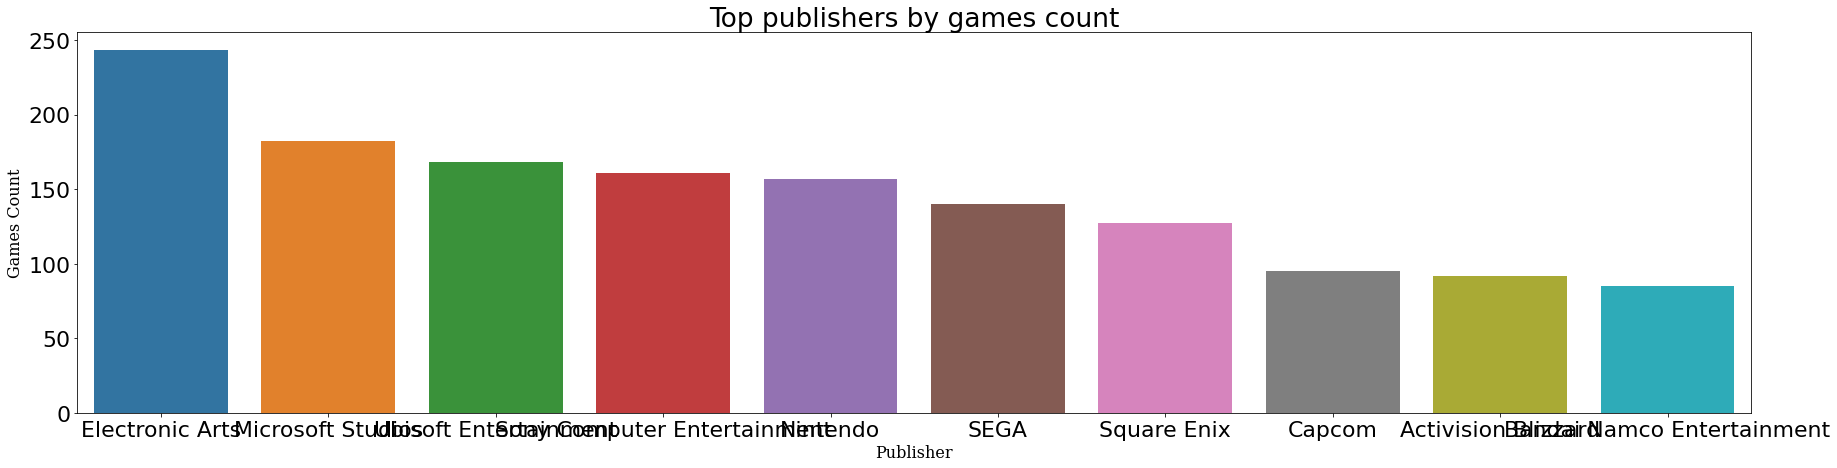

In [154]:
def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type, ax=axis)

fig, axes = plt.subplots(1,1, figsize=(30,7))

# publishers count
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
publisher_game_count = df.groupby("publisher").count().sort_values("game_name", ascending=False).head(10)
publisher_game_count
ax = sns.barplot(publisher_game_count.index, publisher_game_count['game_name'])
ax.set_title("Top publishers by games count")
ax.set_xlabel("Publisher", font)
ax.set_ylabel("Games Count", font)


## Games count by year - Barplot

D:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Games count')

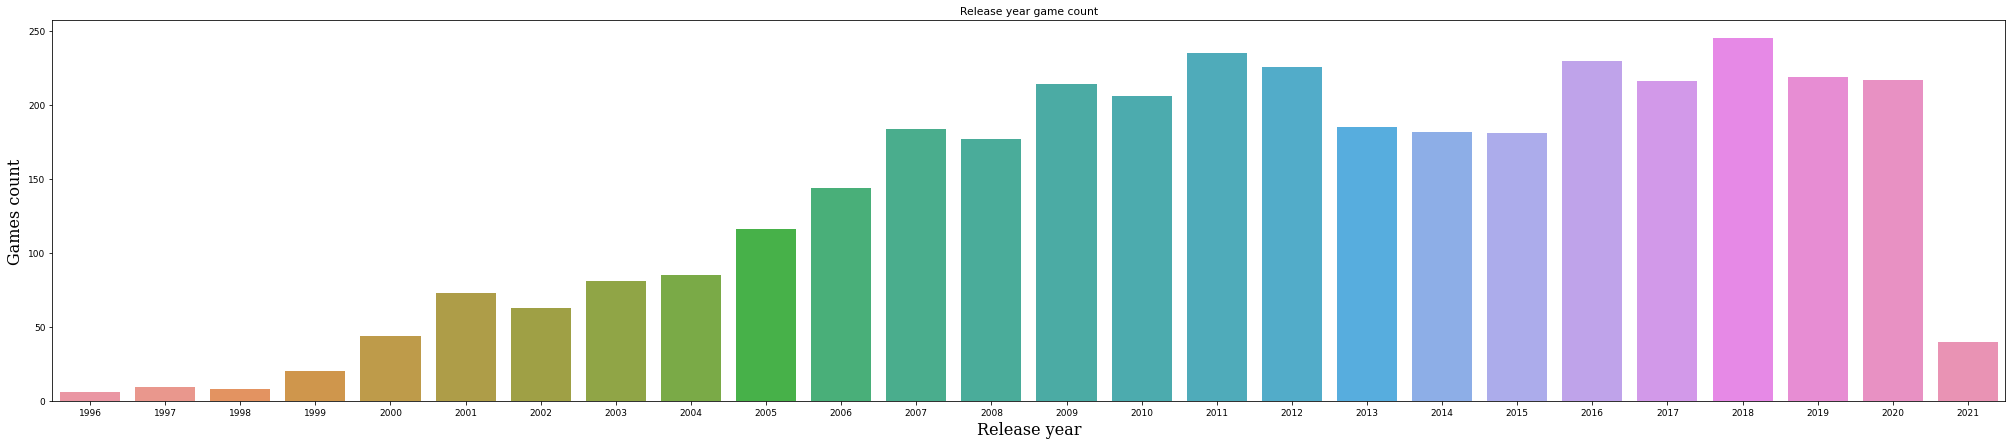

In [77]:
def one_dim_plot(sr, plot_type, axis):
    sr.plot(kind=plot_type, ax=axis)

fig, axes = plt.subplots(1,1, figsize=(35,7))

# publishers count
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
games_count = df.groupby("release_year").count()

ax = sns.barplot(games_count.index, games_count['game_name'])
ax.set_title("Release year game count")
ax.set_xlabel("Release year", font)
ax.set_ylabel("Games count", font)

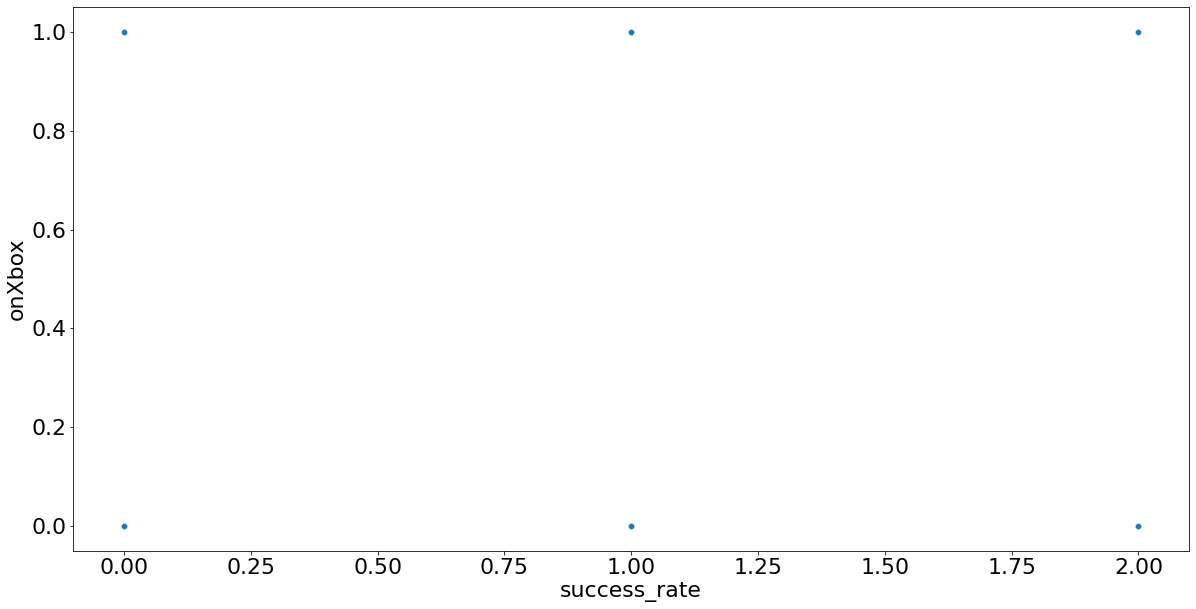

In [400]:
# years = get_frequent_elements(df, 'release_year', 10)
fig, axes = plt.subplots(1,1, figsize=(20,10))

# publishers count
font = {'family': 'serif',
        'weight': 'normal',
        'size': 16}
# success_rate = df.groupby("release_year").groupby('success_rate').count()
# success_rate
ax = sns.scatterplot(data=df, x='success_rate', y="onXbox")
# ax = sns.barplot(x="onXbox", y="onPC", hue="onPlaystation", data=df)
# ax.set_title("Top years by userscore")
# ax.set_xlabel("Years", font)
# ax.set_ylabel("Userscore", font)


## Success rate by release year

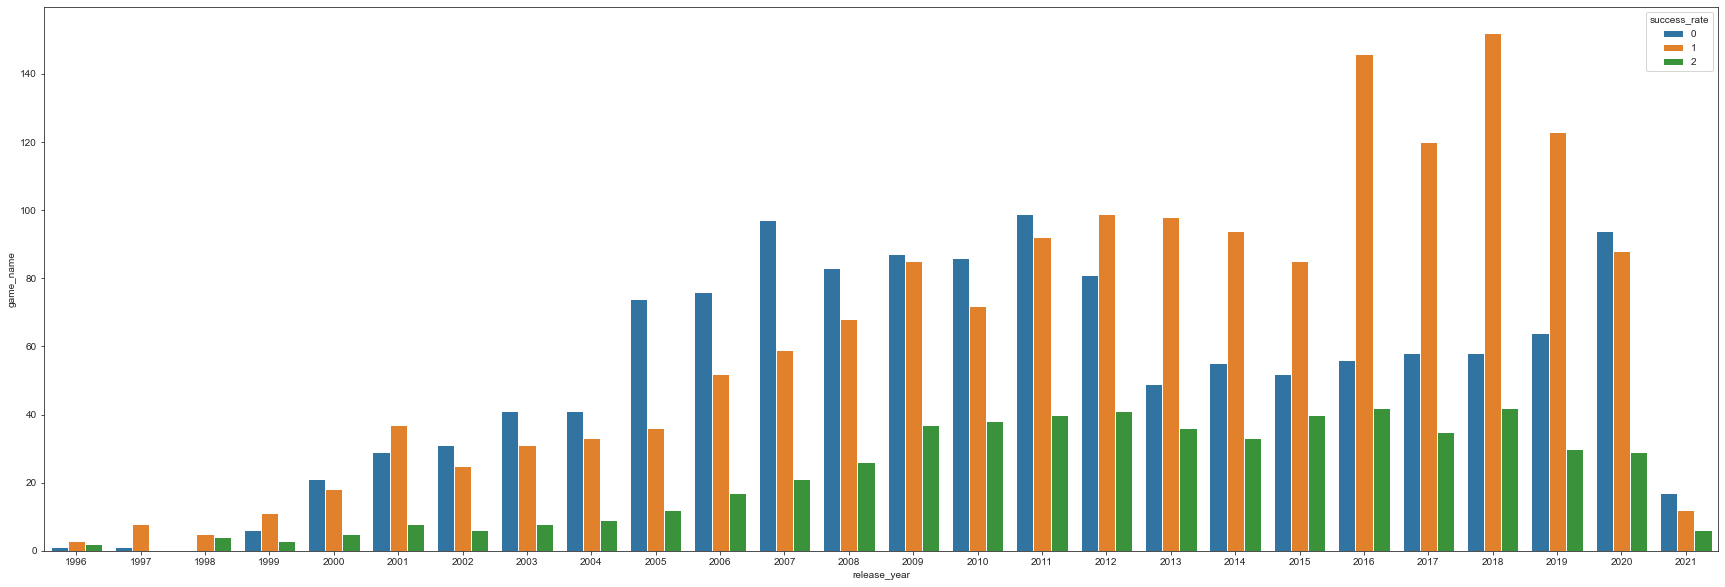

In [286]:
fig, axes = plt.subplots(1,1, figsize=(30,10))
success_rate_count = df.groupby(['release_year' , 'success_rate']).count().reset_index()
success_rate_count.loc[success_rate_count['release_year'] == 2000]['game_name']
ax = sns.barplot(data=success_rate_count, x='release_year', y = 'game_name', hue="success_rate")

## Success rate by genre

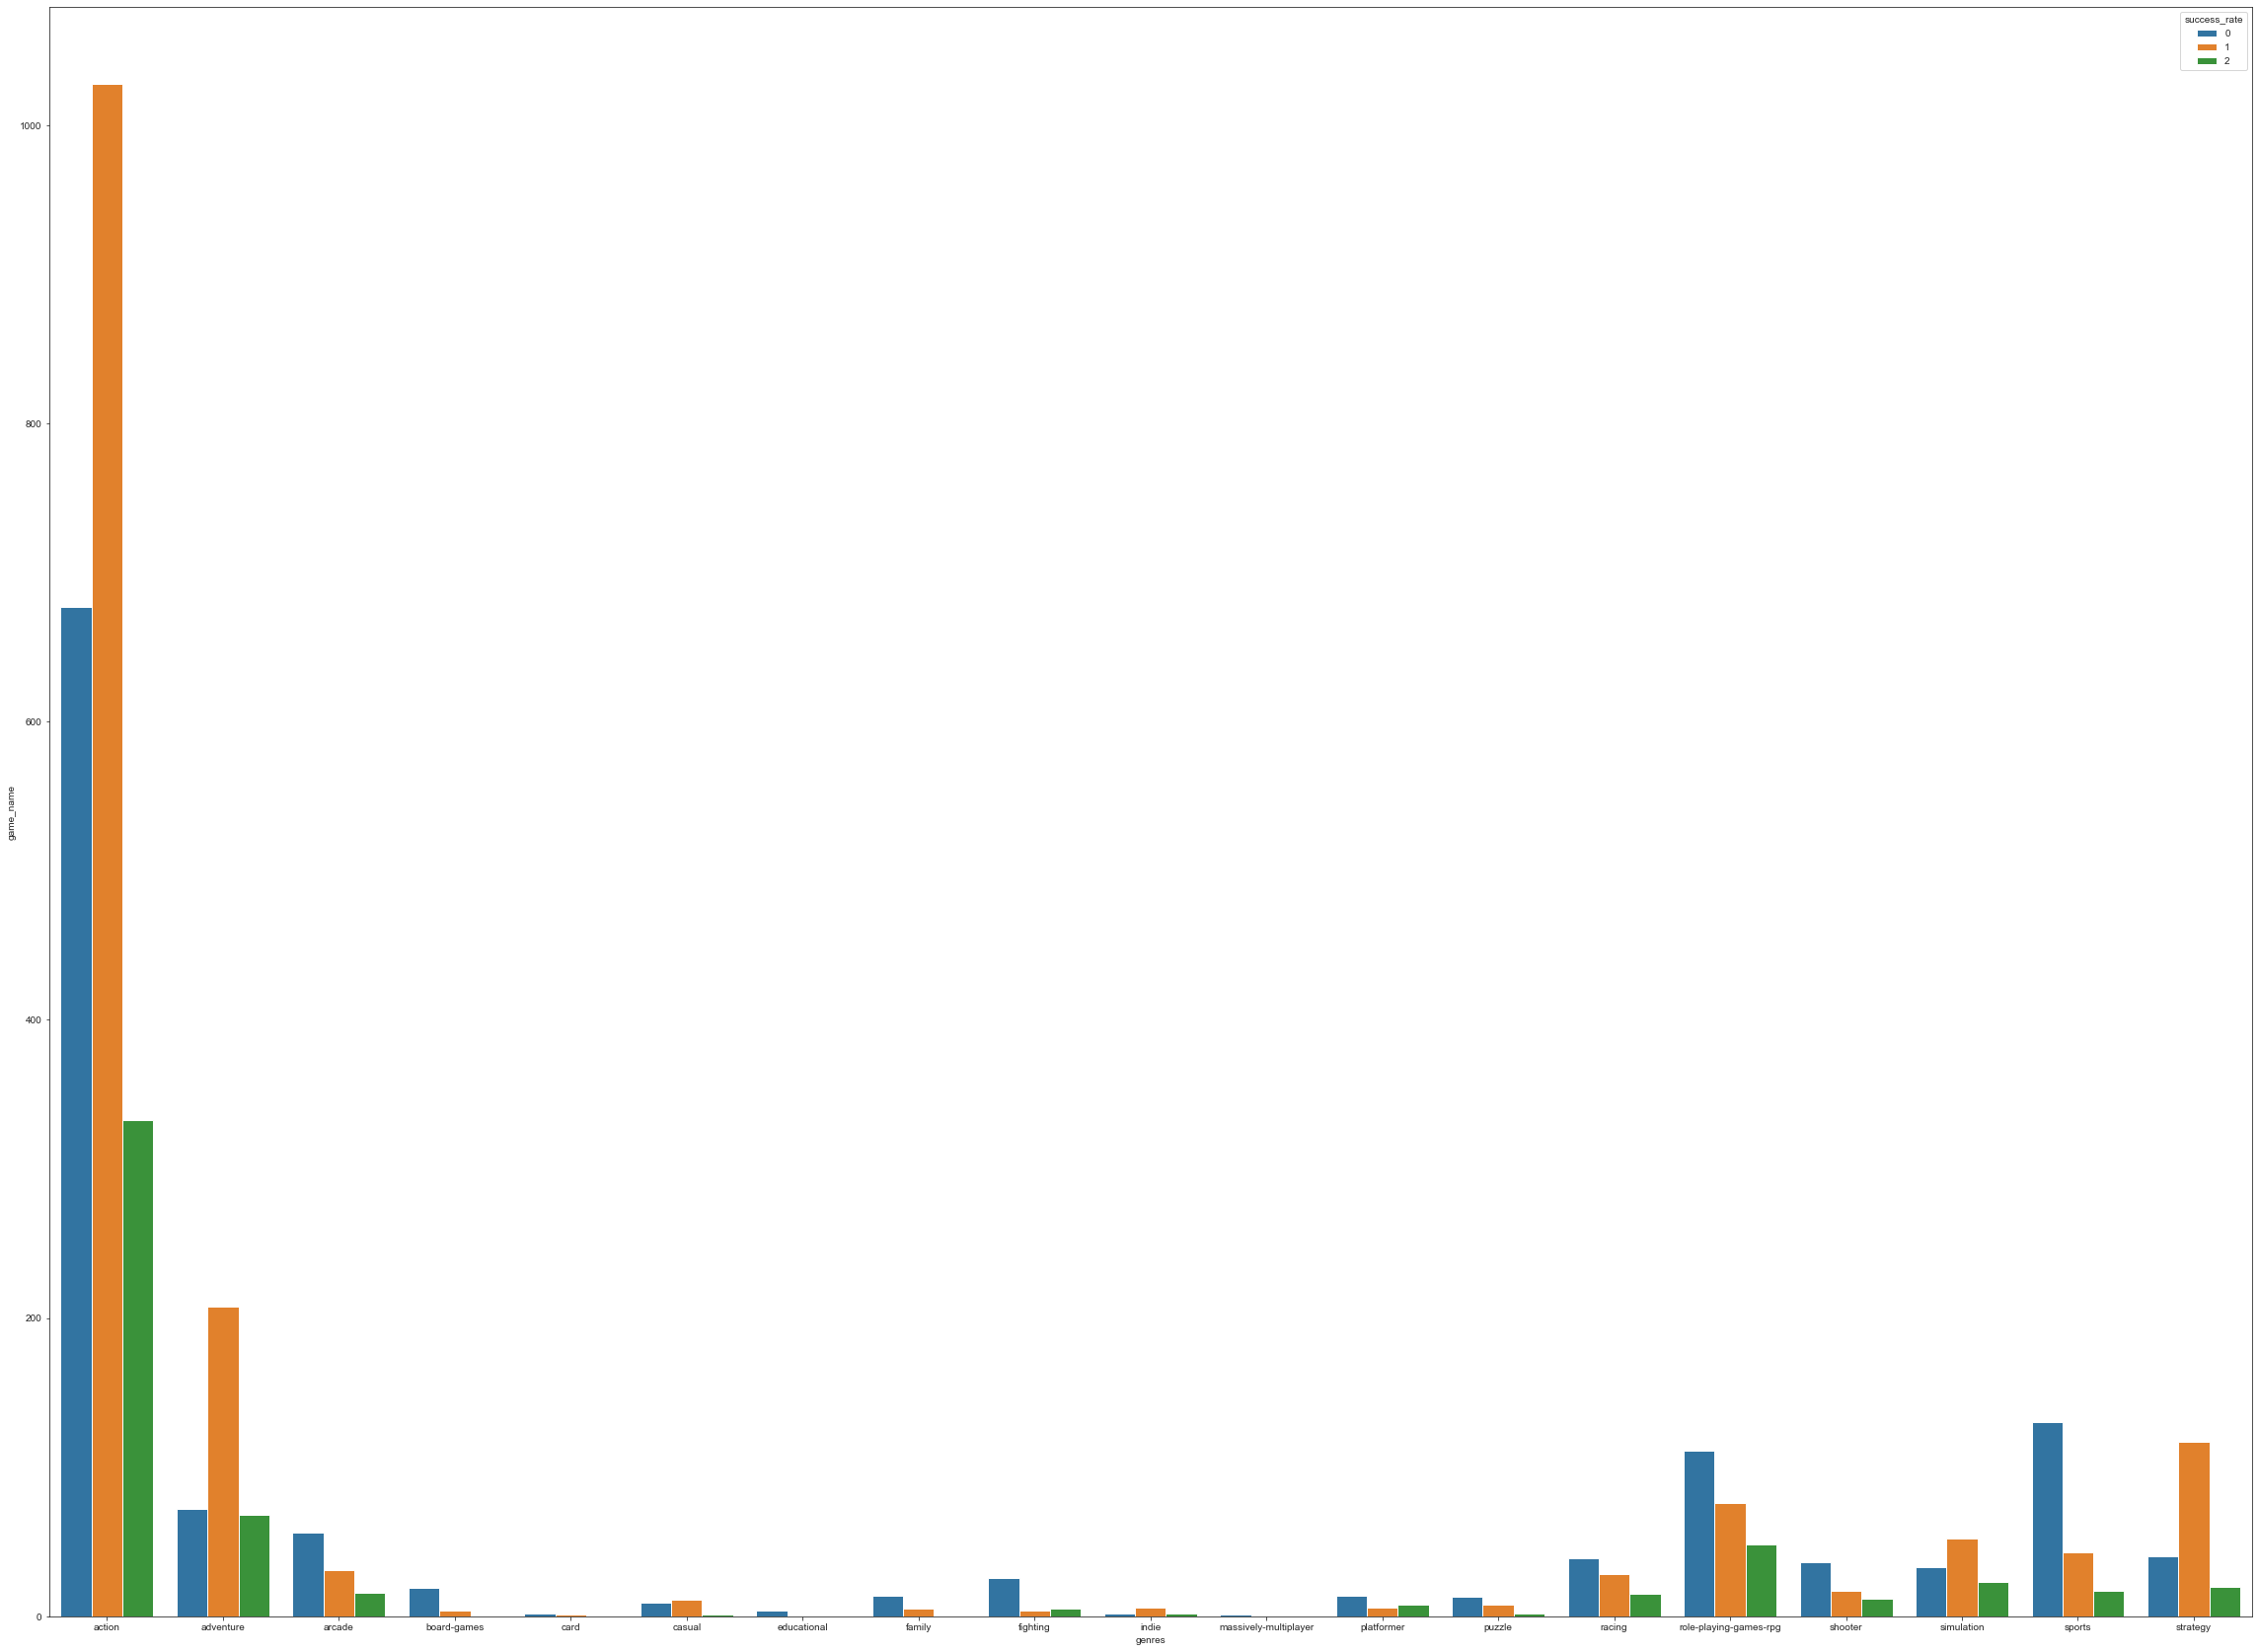

In [291]:
fig, axes = plt.subplots(1,1, figsize=(40,30))
genres_count = df.groupby(['genres' , 'success_rate']).count().reset_index()
genres_count.loc[genres_count['genres'] == 2000]['game_name']
ax = sns.barplot(data=genres_count, x='genres', y = 'game_name', hue="success_rate")

In [406]:
genres_count = df.groupby('genres')['genres'].count().values.tolist()
genres_names = df.groupby('genres')['genres'].count().index.tolist()
print(genres_count, genres_names)
# df[df['genres'] == 'None']
# df['genres'].unique().tolist()

[66, 2038, 348, 103, 23, 3, 21, 4, 19, 35, 10, 1, 28, 23, 82, 235, 65, 108, 190, 177] ['None', 'action', 'adventure', 'arcade', 'board-games', 'card', 'casual', 'educational', 'family', 'fighting', 'indie', 'massively-multiplayer', 'platformer', 'puzzle', 'racing', 'role-playing-games-rpg', 'shooter', 'simulation', 'sports', 'strategy']


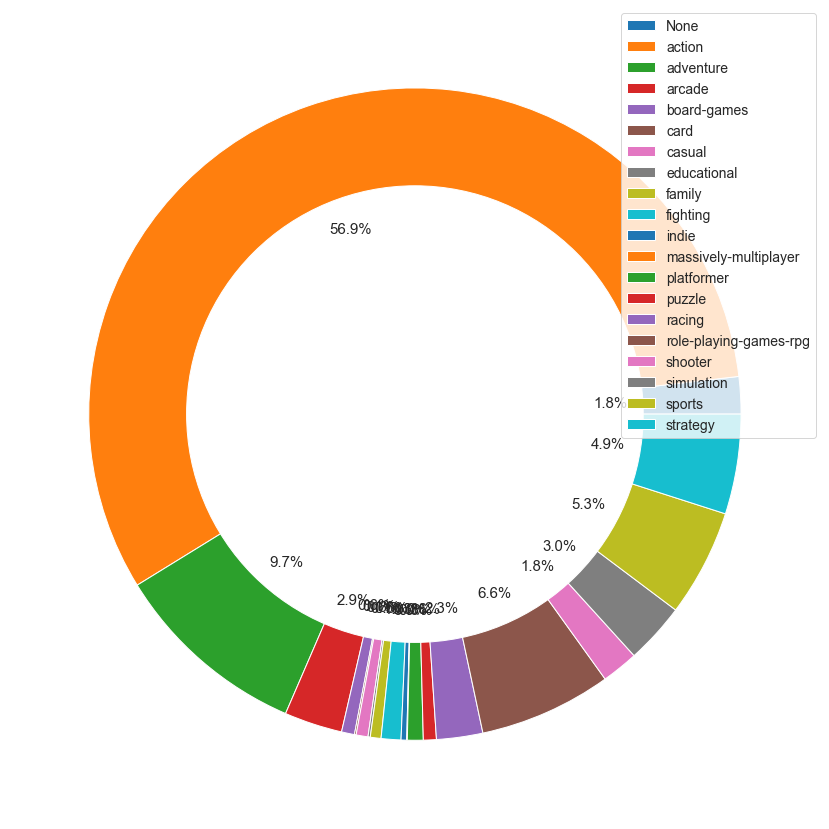

In [449]:
# library
import matplotlib.pyplot as plt
# create data
genres_count = df.groupby('genres')['genres'].count().values.tolist()
genres_names = df.groupby('genres')['genres'].count().index.tolist()

fig, axes = plt.subplots(figsize=(15,15))
# Create a pieplot
axes.pie(genres_count, autopct='%1.1f%%')
# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
axes.legend(genres_names,fontsize=14, loc='upper right')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show(theme)

([<matplotlib.patches.Wedge at 0x214e661dfa0>,
 [Text(1.0796477889657345, 0.5681202793259549, 'High'),
  Text(-0.8177157861383111, 0.735758719350443, 'Medium'),
  Text(0.38102097651862665, -1.0319026191713985, 'Low')],
 [Text(0.6371691869305973, 0.33528409927433395, '15.4%'),
  Text(-0.4460267924390788, 0.4013229378275143, '45.8%'),
  Text(0.20782962355561452, -0.5628559740934901, '38.7%')])

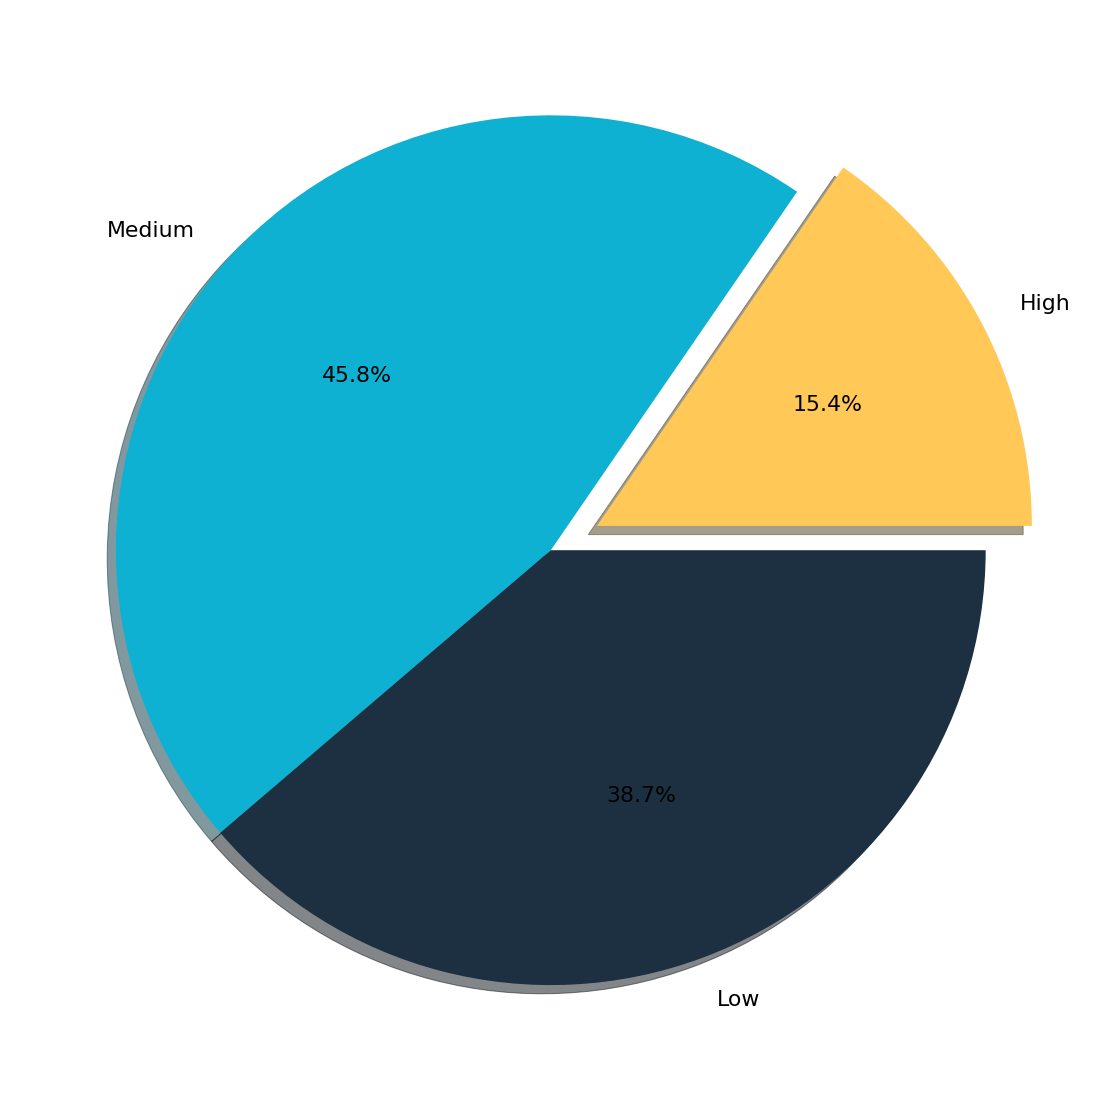

In [95]:
labels = ['High', 'Medium', 'Low']
success_rate_count = df.groupby('success_rate')['success_rate'].count().sort_index(ascending=False)
fig, axes = plt.subplots(figsize=(20,20))
theme = plt.get_cmap('jet')
explode = [0.12, 0, 0]
# axes.set_prop_cycle("color", [theme(1. * i / len(success_rate_count))
#                              for i in range(len(success_rate_count))])
plt.rcParams['font.size'] = 22
axes.pie(success_rate_count, labels=labels, explode=explode, shadow=True, autopct='%1.1f%%', colors=["#FFC857", "#0EB1D2", "#1C3041"])

In [158]:
def get_highly_correlated_cols(df):
    correlations , tuple_arr = [],[]
    col_count = len(df.columns)
    for i in range(col_count):
        for j in range(i+1, col_count):
            pearson=df[df.columns[i]].corr(df[df.columns[j]])
            if pearson >=0.5:
                correlations.append(pearson)
                tuple_arr.append([i,j])
    return correlations, tuple_arr
df
correlations_cols = ['singleplayer', 'multiplayer', 'onXbox', 'onPC', 'ratings_count',
                     'average_playtime', 'onMac', 'onPlaystation', 'onWii', 'release_year', 'success_rate', 'average_score']
correlations, tuple_arr = get_highly_correlated_cols(df[correlations_cols])
print(correlations)
print(tuple_arr)

[0.6665939987353442]
[[0, 3]]


In [160]:

def cross_tabulation(df, col_name, other_col_name):
    return pd.crosstab(df[col_name], df[other_col_name], normalize='index')

def plot_cross_tabulation(df, col_names, other_col_name):
    fig=plt.figure(figsize=(20,5))
    for i in range(len(col_names)):
        subplot=fig.add_subplot(1, 5, i+1)
        sr=cross_tabulation(df,col_names[i], other_col_name)
        one_dim_plot(sr, 'line' , subplot)
df_crosstab = cross_tabulation(df, 'release_year', 'success_rate')
df_crosstab

# plot_cross_tabulation(df, ['metascore', 'userscore'], ['average_playtime'])

success_rate,0,1,2
release_year,,,
1996,0.166667,0.500000,0.333333
1997,0.111111,0.888889,0.000000
1998,0.000000,0.625000,0.375000
1999,0.300000,0.550000,0.150000
2000,0.477273,0.386364,0.136364
2001,0.383562,0.506849,0.109589
2002,0.492063,0.412698,0.095238
2003,0.530864,0.382716,0.086420
2004,0.494118,0.400000,0.105882


## Machine Learning

In [345]:
def prepare_dataset_for_ml(df):
    df2 = df.copy()
    drop_columns = ["game_name", "publisher", "developer", 'userscore', 'metascore']
    df2.drop(columns=drop_columns, axis=1, inplace=True)
    df2 = pd.get_dummies(df2, columns=["maturity_rating", 'genres'])
    return df2

def calc_evaluation_val(eval_metric, y_test, y_predicted):
    if eval_metric == 'accuracy':
        evaluation_val = accuracy_score(y_true=y_test, y_pred=y_predicted)
    elif eval_metric == 'precision':
        evaluation_val = precision_score(y_true=y_test, y_pred=y_predicted, average='micro')
    elif eval_metric == 'recall':
        evaluation_val = recall_score(y_true=y_test, y_pred=y_predicted, average='micro')
    elif eval_metric == 'f1':
        evaluation_val = f1_score(y_true=y_test, y_pred=y_predicted, average='micro')
    elif eval_metric == 'confusion_matrix':
        evaluation_val = confusion_matrix(y_true=y_test, y_pred=y_predicted)
    return evaluation_val

def find_best_model(X_train, y_train, max_depth_val, min_samples_split_val):
    
        clf1 = DecisionTreeClassifier(max_depth=max_depth_val, min_samples_split=min_samples_split_val)
        clf2 = GaussianNB()
        clf3 = svm.SVC()

        classifiers = [clf1,clf2,clf3]
        best_recall_val = 0
        maxIndex = 0
        for index, clf in enumerate(classifiers):
            clf.fit(X_train, y_train)
            yPredTrain = clf.predict(X_train)
            if best_recall_val < recall_score(y_true=y_train, y_pred=yPredTrain, average='micro'):
                best_recall_val = recall_score(y_true=y_train, y_pred=yPredTrain, average='micro')
                maxIndex = index

        best_clf = classifiers[maxIndex]

        return best_clf, best_recall_val

df

,game_name,metascore,userscore,publisher,developer,maturity_rating,singleplayer,multiplayer,onXbox,onPC,...,youtube_videos_count,achievements_count,ratings_count,average_playtime,game_series_count,genres,onMobile,release_year,average_score,success_rate
0,INSIDE,93,8.3,Playdead,Playdead,T,1,0,1,1,...,1000000,14,1786,4.0,0,action,1,2016,88.0,2
1,Burnout 3: Takedown,93,9.0,Electronic Arts,Criterion Games,T,0,1,1,0,...,159866,0,104,23.0,3,racing,0,2004,91.5,2
2,The Elder Scrolls V: Skyrim,92,6.6,Bethesda Softworks,Bethesda Softworks,M,1,0,1,1,...,1000000,76,3380,45.0,14,action,0,2011,79.0,2
3,Persona 4 Golden,93,8.6,SEGA,Atlus,M,1,0,0,1,...,1000000,36,397,5.0,8,role-playing-games-rpg,0,2012,89.5,2
4,SSX 3,93,8.8,Electronic Arts,Electronic Arts Canada,E,1,1,1,0,...,0,0,26,0.0,6,sports,0,2003,90.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3601,Deca Sports Freedom,26,3.7,Hudson Entertainment,HUDSON SOFT CO.,E,0,0,1,0,...,0,0,1,0.0,0,sports,0,2010,31.5,0
3602,Kengo: Legend of the 9,38,4.1,Genki,GENKI,M,0,0,1,0,...,0,21,3,0.0,0,action,0,2007,39.5,0
3603,Things on Wheels,41,6.0,LOAD,LOAD,E,0,0,1,0,...,0,5,1,0.0,0,racing,0,2010,50.5,0
3604,Umbrella Corps,36,2.0,Capcom,Capcom,M,1,1,0,1,...,192642,41,61,5.0,21,action,0,2016,28.0,0


## Preparing Dataset for ML

In [358]:
y = df['success_rate']
X = prepare_dataset_for_ml(df)
X.drop(columns=['success_rate', 'onAndroid', 'onIOS'], inplace=True)

## Logistic Regression

In [381]:
# Normalize data
x = X.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

# Split test and train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=50)

In [411]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
pred_vals = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, pred_vals)
clf_accuracy

0.7839335180055401

## Decision Tree

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=100)
# decisionTree = tree.DecisionTreeClassifier()
# decisionTree = decisionTree.fit(X_train, y_train)
# pred_vals = decisionTree.predict(X_test)

# measure accuracy
# print('Accuracy on training data = ', accuracy_score(y_test, pred_vals))
# len(y_pred_train)
# pd.DataFrame({"predict": y_pred_train, "original": y_train})

## RandomForest

In [401]:
max_dep=4
min_smpl_splt=5
best_clf, best_recall_val=find_best_model(X_train, y_train, max_dep, min_smpl_splt)
print(best_clf, best_recall_val)

DecisionTreeClassifier(max_depth=4, min_samples_split=5) 1.0


## KNN

In [397]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
pred_vals = clf.predict(X_test)
pred_vals

print(calc_evaluation_val("accuracy", y_test, pred_vals))

0.6952908587257618


## Bonus

In [425]:
import requests
import json
import bs4
from bs4 import BeautifulSoup
import pandas as pd

url = "http://open.mapquestapi.com/geocoding/v1/address?key=zUeYsAeDlnxz2OmKnbBGW2GtU5VESp0B&location=United states"
wikipedia_url = "https://en.wikipedia.org/wiki/List_of_video_game_publishers"
r = requests.get(wikipedia_url)
soup = BeautifulSoup(r.content, "html.parser")
table = soup.select("table.wikitable.sortable")[0]
body = table.select("tbody")[0]
records = body.select("tr")
publishers_df = pd.DataFrame()
publishers = []
locations = []
for i in range(1, len(records)):
    tds = records[i].find_all("td")
    publisher = tds[0].text
    if not len(publisher):
        publisher = tds[0].select("a")[0].text
    publishers.append(publisher.replace("\n", "").lower())

    location = tds[1].text
    if not len(publisher):
        location = tds[1].select("a")[0].text
    locations.append(location.replace("\n", "").lower())

publishers_df = pd.DataFrame({"publisher": publishers, "address": locations})
publishers_df[publishers_df['publisher'] == 'Playdead'.lower()]
# publishers_df

# for row in df:
#     row['location'] = publishers_df[publishers_df['publisher'] == row['publisher']]['location']


,publisher,address
